#Classification of Monophonic Guitar Notes Across Strings in
#Noisy Environments

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


#Importing the files

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Guitarset/audio_hex-pickup_debleeded")


In [ ]:
!wget "https://zenodo.org/record/3371780/files/audio_hex-pickup_debleeded.zip?download=1" -O audio_hex-pickup_debleeded.zip
!unzip -o audio_hex-pickup_debleeded.zip

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Guitarset/annotation")


In [ ]:
!wget "https://zenodo.org/record/3371780/files/annotation.zip?download=1" -O annotation.zip

# Unzip the annotation.zip file:
!unzip -o annotation.zip


#Necessary package installations

In [ ]:
!pip install librosa numpy matplotlib seaborn pandas jams tqdm scikit-learn imbalanced-learn tensorflow keras keras-tuner pydot graphviz

#Importing necessary libraries

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from IPython.display import Audio, display
import pandas as pd
import jams
import os
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import StratifiedKFold
import keras_tuner as kt
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report


#Spectogram Visualization

In [ ]:
# directory where your audio files are
audio_dir = '/content/gdrive/MyDrive/Guitarset/audio_hex-pickup_debleeded'

# lists to hold all data, sampling rates, and file names
all_data = []
all_sampling_rates = []
all_file_names = []

# iterate over all files in the directory
for filename in os.listdir(audio_dir):
    # ensure the file is an audio file
    if filename.endswith('.wav'):  # or '.mp3' or any other audio format
        # construct full file path
        file_path = os.path.join(audio_dir, filename)
        # load the file
        data, sampling_rate = librosa.load(file_path)
        # add data, sampling rate, and file name to lists
        all_data.append(data)
        all_sampling_rates.append(sampling_rate)
        all_file_names.append(filename)

# select the first audio file from your list
data = all_data[0]
sampling_rate = all_sampling_rates[0]

# Compute the spectrogram magnitude and display it
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# Display the audio player with the file name
print("Playing audio file: " + all_file_names[0])
audio = Audio(all_data[0], rate=all_sampling_rates[0])
display(audio)


Playing audio file: 01_Rock2-85-F_solo_hex_cln.wav


#Feature extraction and label preparation

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)

def midi_to_pitch(midi_num):
    note_names = ['C', 'C♯', 'D', 'D♯', 'E', 'F', 'F♯', 'G', 'G♯', 'A', 'A♯', 'B']
    octave = midi_num // 12 - 1
    note = note_names[midi_num % 12]
    return f'{note}{octave}'

# Directories where your audio files and annotations are
audio_dir = '/content/gdrive/MyDrive/Guitarset/audio_hex-pickup_debleeded'
annotation_dir = '/content/gdrive/MyDrive/Guitarset/annotation'

# Get the list of audio files
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

# List to hold all features for all files
all_features = []

n_fft = 1024

# Iterate over the files in the audio directory
for filename in tqdm(audio_files, desc="Processing files"):
    audio_path = os.path.join(audio_dir, filename)
    data, sampling_rate = librosa.load(audio_path, sr=None, mono=False)

    # Get string and note information
    annotation_filename = filename.replace('_hex_cln.wav', '.jams')
    annotation_path = os.path.join(annotation_dir, annotation_filename)
    jam = jams.load(annotation_path)

    for string_idx in range(6):
        # Extract pitch contour annotation for the current string
        pitch_contour_annotation = jam.annotations.search(namespace=f'pitch_contour')[string_idx]
        pitch_contour_frequencies = [obs.value['frequency'] for obs in pitch_contour_annotation.data]

        # Calculate pitch contour features
        pitch_contour_mean = np.mean(pitch_contour_frequencies) if pitch_contour_frequencies else 0
        pitch_contour_std = np.std(pitch_contour_frequencies) if pitch_contour_frequencies else 0

        midi_note_annotation = jam.annotations.search(namespace=f'note_midi')[string_idx]

        for obs in midi_note_annotation.data:
            midi_num = int(obs.value)
            start_time = obs.time
            end_time = start_time + obs.duration
            start_sample = librosa.time_to_samples(start_time, sr=sampling_rate)
            end_sample = librosa.time_to_samples(end_time, sr=sampling_rate)
            string_data = data[string_idx, start_sample:end_sample]

            # Pad the segment if it's shorter than n_fft
            if len(string_data) < n_fft:
                string_data = np.pad(string_data, (0, n_fft - len(string_data)), 'constant')

            # Extract features from the segment
            stft = np.abs(librosa.stft(string_data, n_fft=n_fft))
            spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sampling_rate))
            chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate))
            mfccs = np.mean(librosa.feature.mfcc(S=librosa.power_to_db(stft), sr=sampling_rate))
            spectral_centroids = np.mean(librosa.feature.spectral_centroid(y=string_data, sr=sampling_rate))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=string_data, sr=sampling_rate))
            spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=string_data))
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=string_data))
            tonnetz = np.mean(librosa.feature.tonnetz(y=string_data, sr=sampling_rate))
            note = midi_to_pitch(midi_num)
            harmonic, percussive = librosa.effects.hpss(string_data)
            hnr = np.mean(harmonic) / (np.mean(percussive) + 1e-6)

            features = {
                'filename': filename,
                'string': string_idx + 1,
                'note': note,
                'midi_num':midi_num,
                'pitch_contour_mean': pitch_contour_mean,
                'pitch_contour_std': pitch_contour_std,
                'spectral_centroid': spectral_centroids,
                'spectral_rolloff': spectral_rolloff,
                'spectral_contrast': spectral_contrast,
                'spectral_flatness': spectral_flatness,
                'mfccs': mfccs,
                'chroma_stft': chroma_stft,
                'zero_crossing_rate': zero_crossing_rate,
                'tonnetz': tonnetz.tolist(),
                'hnr':hnr
            }

            # Add features to the list
            all_features.append(features)

# Convert all_features to a DataFrame
final_features_df = pd.DataFrame(all_features)

# Save the final DataFrame to a CSV file if needed
final_features_df.to_csv('final_features.csv', index=False)


Processing files: 100%|██████████| 360/360 [2:59:49<00:00, 29.97s/it]


In [ ]:
final_features_df

filename  string note  midi_num  \
0       01_Rock2-85-F_solo_hex_cln.wav       3  A♯3        58   
1       01_Rock2-85-F_solo_hex_cln.wav       3  A♯3        58   
2       01_Rock2-85-F_solo_hex_cln.wav       3  A♯3        58   
3       01_Rock2-85-F_solo_hex_cln.wav       3  A♯3        58   
4       01_Rock2-85-F_solo_hex_cln.wav       3  A♯3        58   
...                                ...     ...  ...       ...   
62471  05_Rock1-90-C#_solo_hex_cln.wav       6  G♯4        68   
62472  05_Rock1-90-C#_solo_hex_cln.wav       6  D♯5        75   
62473  05_Rock1-90-C#_solo_hex_cln.wav       6   B4        71   
62474  05_Rock1-90-C#_solo_hex_cln.wav       6  C♯5        73   
62475  05_Rock1-90-C#_solo_hex_cln.wav       6   A4        69   

       pitch_contour_mean  pitch_contour_std  spectral_centroid  \
0              233.516492          44.036324        1135.457332   
1              233.516492          44.036324        1039.365406   
2              233.516492          44.036324        1197.958623   
3              233.516492          44.036324        1036.677941   
4              233.516492          44.036324         835.158402   
...                   ...                ...                ...   
62471          502.740799          65.408713        1739.772415   
62472          502.740799          65.408713        3462.931305   
62473          502.740799          65.408713        2229.924898   
62474          502.740799          65.408713        2905.697901   
62475          502.740799          65.408713        2053.467418   

       spectral_rolloff  spectral_contrast  spectral_flatness      mfccs  \
0           2116.534424          18.247096           0.000147  -4.637296   
1           1819.555664          19.361501           0.000076  -5.254897   
2           2102.563477          17.922429           0.000498  -3.536186   
3           1836.303711          19.196518           0.000372  -4.340566   
4           1270.458984          18.637535           0.000061  -6.081200   
...                 ...                ...                ...        ...   
62471       2879.707031          21.367950           0.000800 -14.881587   
62472       6656.835938          21.827672           0.002313 -12.218781   
62473       4647.371898          22.548628           0.000921 -15.839594   
62474       5846.264648          23.074993           0.001528 -11.246113   
62475       3925.989163          20.550109           0.002131 -16.503702   

       chroma_stft  zero_crossing_rate   tonnetz       hnr  
0         0.555650            0.021667 -0.088351  0.455079  
1         0.495370            0.022115 -0.102312  8.097184  
2         0.536960            0.014927 -0.085475  0.629371  
3         0.500143            0.019368 -0.097769  0.351138  
4         0.493178            0.016507 -0.119629  1.680053  
...            ...                 ...       ...       ...  
62471     0.357019            0.018978 -0.077697  0.370771  
62472     0.359963            0.062640  0.032828  1.140398  
62473     0.325826            0.031623 -0.002872  0.236354  
62474     0.284082            0.037305 -0.201592  1.690113  
62475     0.381572            0.027501 -0.104405  0.217398  

[62476 rows x 15 columns]

In [ ]:
final_features_df[['string']].value_counts()

string
4         15355
3         14056
5         12843
2          9047
6          6537
1          4638
dtype: int64

#Data Exploration


Visualizing the audio

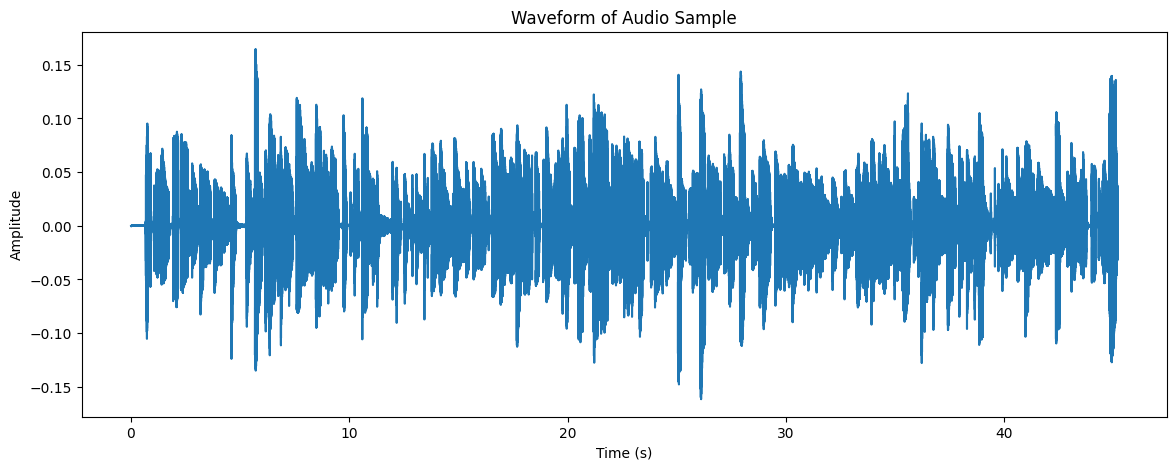

In [ ]:
# Select a specific audio file
filename = os.listdir(audio_dir)[0]
audio_path = os.path.join(audio_dir, filename)

# Load the audio file
y, sr = librosa.load(audio_path)

# Create an array with time values
t = np.arange(len(y)) / sr

# Plot the audio file
plt.figure(figsize=(14, 5))

# The x-axis represents time in seconds and the y-axis represents the amplitude of the audio signal
# The amplitude of the waveform at a given point in time corresponds to the loudness of the sound at that time
plt.plot(t, y)

plt.title('Waveform of Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


Correlation Analysis

<ipython-input-17-b0af6903c864>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_features_df.corr()


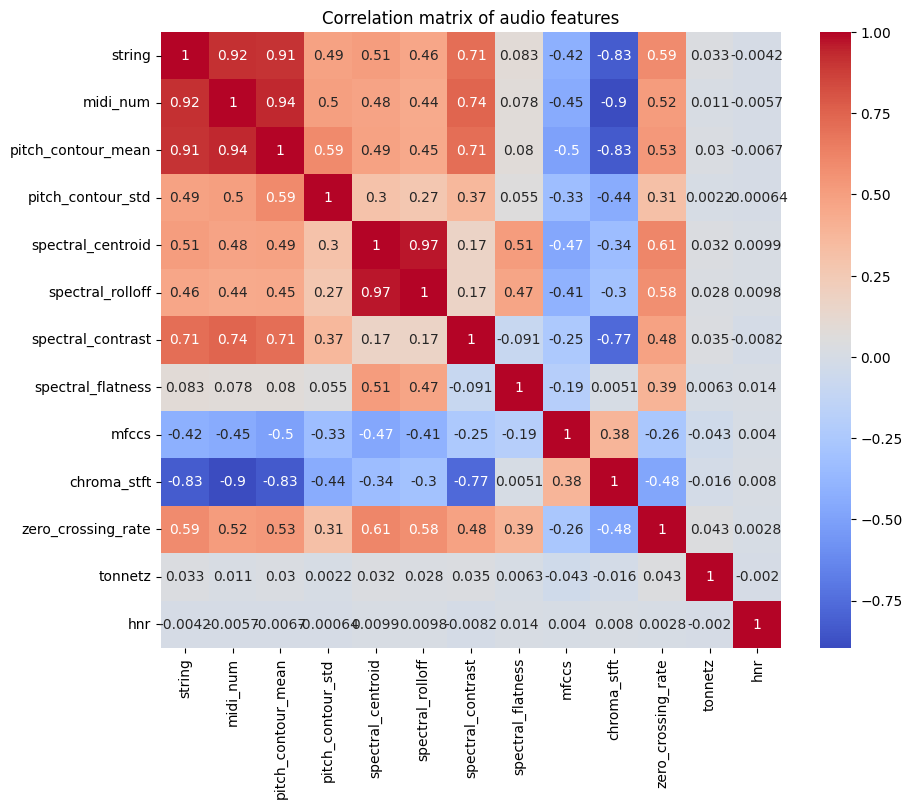

In [ ]:
# Use seaborn's pairplot function to visualize correlations
sns.pairplot(final_features_df[['string','note','midi_num','spectral_centroid','spectral_rolloff','spectral_contrast', 'spectral_flatness','chroma_stft', 'mfccs',  'zero_crossing_rate', 'tonnetz','hnr']])

# Compute the correlation matrix and display it
corr_matrix = final_features_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of audio features')
plt.show()


Class Distribution

In [ ]:
final_features_df[['string','note']].value_counts()

string  note
4       C♯4     2284
3       G♯3     2202
4       D4      1735
5       F4      1719
3       F3      1704
                ... 
        G4         1
4       C5         1
1       F♯3        1
2       A♯3        1
5       F5         1
Length: 110, dtype: int64

In [ ]:
# Combine the 'note' and 'midi_num' columns into a single string
final_features_df['note_midi'] = final_features_df['note'] + '_' + final_features_df['midi_num'].astype(str)

plt.figure(figsize=(20, 10))
sns.countplot(x="note_midi", hue="string", data=final_features_df, palette="Set2")
plt.title('Note and MIDI Number Distribution Per String')
plt.xlabel('Note and MIDI Number', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='String', loc='upper right')
plt.show()


#Balancing the dataset

In [ ]:
final_features_df.columns

Index(['filename', 'string', 'note', 'midi_num', 'pitch_contour_mean',
       'pitch_contour_std', 'spectral_centroid', 'spectral_rolloff',
       'spectral_contrast', 'spectral_flatness', 'mfccs', 'chroma_stft',
       'zero_crossing_rate', 'tonnetz', 'hnr', 'note_midi'],
      dtype='object')

In [ ]:
# Define features and labels
X = final_features_df.drop(columns=['filename', 'string', 'note', 'midi_num', 'tonnetz', 'spectral_flatness', 'hnr','note_midi'])
y_string = final_features_df['string']
y_note = final_features_df['note']

# Label Encoding (before splitting)
string_encoder = LabelEncoder()
note_encoder = LabelEncoder()
y_string_encoded = string_encoder.fit_transform(y_string)
y_note_encoded = note_encoder.fit_transform(y_note)

# Data Splitting
X_train, X_test, y_string_train, y_string_test, y_note_train, y_note_test = train_test_split(X, y_string_encoded, y_note_encoded, test_size=0.2, random_state=42)

# Outlier Treatment
z_scores_train = stats.zscore(X_train)
threshold = 3
outliers_train = np.where(np.abs(z_scores_train) > threshold)
X_train_no_outliers = X_train[(np.abs(z_scores_train) < threshold).all(axis=1)]
y_string_train_no_outliers = [y_string_train[i] for i in range(len(y_string_train)) if i not in outliers_train[0]]
y_note_train_no_outliers = [y_note_train[i] for i in range(len(y_note_train)) if i not in outliers_train[0]]

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_scaled = scaler.transform(X_test)

# Balancing
ros_note = RandomOverSampler()
X_train_after_note_balancing, y_note_train_after_note_balancing = ros_note.fit_resample(X_train_scaled, y_note_train_no_outliers)
y_string_train_list = y_string_train_no_outliers
y_string_train_after_note_balancing = [y_string_train_list[idx] for idx in ros_note.sample_indices_]
ros_string = RandomOverSampler()
X_train_balanced, y_string_train_balanced = ros_string.fit_resample(X_train_after_note_balancing, y_string_train_after_note_balancing)
y_note_train_list = y_note_train_after_note_balancing  # Removed .tolist()
y_note_train_balanced = [y_note_train_list[idx] for idx in ros_string.sample_indices_]

# Determine the total number of unique classes for the notes
total_note_classes = max(y_note_encoded) + 1

# Convert to one-hot encoding
y_string_train_one_hot = to_categorical(y_string_train_balanced)
y_string_test_one_hot = to_categorical(y_string_test, num_classes=y_string_train_one_hot.shape[1])
y_note_train_one_hot = to_categorical(y_note_train_balanced, num_classes=total_note_classes)
y_note_test_one_hot = to_categorical(y_note_test, num_classes=total_note_classes)

# Data Augmentation
def augment_data(data, noise_factor=0.1):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=data.shape)
    return data + noise

X_train = augment_data(X_train_balanced)
X_test = augment_data(X_test_scaled)

# Reshape the features for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print(y_string_train_one_hot.shape)
print(y_string_test_one_hot.shape)
print(y_note_train_one_hot.shape)
print(y_note_test_one_hot.shape)

(169422, 6)
(12496, 6)
(169422, 42)
(12496, 42)


#Splitting the dataset to train and test

In [ ]:
# Check the balance in the training set for y_string
train_counts_string = np.sum(y_string_train_one_hot, axis=0)
print("Training class counts for y_string:")
print({string_encoder.inverse_transform([k])[0]: int(v) for k, v in enumerate(train_counts_string)})

# Check the balance in the test set for y_string
test_counts_string = np.sum(y_string_test_one_hot, axis=0)
print("Test class counts for y_string:")
print({string_encoder.inverse_transform([k])[0]: int(v) for k, v in enumerate(test_counts_string)})

# Check the balance in the training set for y_note
train_counts_note = np.sum(y_note_train_one_hot, axis=0)
print("Training class counts for y_note:")
print({note_encoder.inverse_transform([k])[0]: int(v) for k, v in enumerate(train_counts_note)})

# Check the balance in the test set for y_note
test_counts_note = np.sum(y_note_test_one_hot, axis=0)
print("Test class counts for y_note:")
print({note_encoder.inverse_transform([k])[0]: int(v) for k, v in enumerate(test_counts_note)})


Training class counts for y_string:
{1: 28237, 2: 28237, 3: 28237, 4: 28237, 5: 28237, 6: 28237}
Test class counts for y_string:
{1: 922, 2: 1815, 3: 2873, 4: 3008, 5: 2540, 6: 1338}
Training class counts for y_note:
{'A2': 4351, 'A3': 5202, 'A4': 3619, 'A♯2': 4172, 'A♯3': 5156, 'A♯4': 3425, 'B2': 4478, 'B3': 4981, 'B4': 3357, 'C3': 4683, 'C4': 5048, 'C5': 3123, 'C♯3': 4619, 'C♯4': 5059, 'C♯5': 2972, 'D3': 4877, 'D4': 4904, 'D5': 2973, 'D♯2': 3798, 'D♯3': 4788, 'D♯4': 4807, 'D♯5': 2975, 'E2': 3810, 'E3': 4936, 'E4': 4511, 'E5': 2774, 'F2': 3870, 'F3': 4822, 'F4': 4381, 'F5': 2858, 'F♯2': 3814, 'F♯3': 4854, 'F♯4': 4299, 'F♯5': 2774, 'G2': 3767, 'G3': 5074, 'G4': 4068, 'G5': 2774, 'G♯2': 3863, 'G♯3': 4983, 'G♯4': 3823, 'G♯5': 0}
Test class counts for y_note:
{'A2': 227, 'A3': 565, 'A4': 283, 'A♯2': 189, 'A♯3': 614, 'A♯4': 224, 'B2': 238, 'B3': 573, 'B4': 179, 'C3': 266, 'C4': 613, 'C5': 154, 'C♯3': 336, 'C♯4': 652, 'C♯5': 108, 'D3': 346, 'D4': 641, 'D5': 54, 'D♯2': 15, 'D♯3': 332, 'D♯4':

#Model Building

In [ ]:

# Custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
#Custom F1 Score metric class to calculate F1 Score during model training.

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def result(self):
        return 2 * ((self.precision.result() * self.recall.result()) /
                    (self.precision.result() + self.recall.result() + tf.keras.backend.epsilon()))

def build_model(hp):
  #Build and return a CNN model based on hyperparameters.

  #Input Layer
    input_layer = layers.Input(shape=(X_train.shape[1], 1))
    # Convolutional layer with hyperparameter tuning options for filter size and kernel size
    x = layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)
    )(input_layer)
    x = BatchNormalization()(x)

# MaxPooling layer if the shape allows
    if x.shape[1] > 1:
        x = layers.MaxPooling1D(pool_size=2)(x)

# Dropout layer with hyperparameter tuning options for dropout rate
    x = layers.Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4, 0.5]))(x)

    # Flatten and Dense layer with hyperparameter tuning options for number of units
    x = layers.Flatten()(x)
    x = layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)
    )(x)
    x = BatchNormalization()(x)
# Output layers for string and note classification
    string_output = layers.Dense(y_string_train_one_hot.shape[1], activation='softmax', name='string_output')(x)
    note_output = layers.Dense(y_note_train_one_hot.shape[1], activation='softmax', name='note_output')(x)
# Construct and compile the model
    model = keras.Model(inputs=input_layer, outputs=[string_output, note_output])
# Optimizer with hyperparameter tuning options for learning rate
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer,
                  loss={'string_output': 'categorical_crossentropy', 'note_output': 'categorical_crossentropy'},
                  metrics=[tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           F1Score(name='f1_score'),
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model


#Hyperparameter tuning

In [ ]:

# Assuming the build_model function is defined
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=5,
    directory='output',
    project_name="Music_Note_Classification"
)

stop_early = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Combining y_string and y_note into one label for stratification AFTER balancing
combined_labels_train_balanced = [f"{str_label}_{note_label}" for str_label, note_label in zip(y_string_train_balanced, y_note_train_balanced)]

kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Using combined_labels_train_balanced for splitting
for train, test in kfold.split(X_train, combined_labels_train_balanced):
    tuner.search(X_train[train], [y_string_train_one_hot[train], y_note_train_one_hot[train]], epochs=50,
                 validation_data=(X_train[test], [y_string_train_one_hot[test], y_note_train_one_hot[test]]),
                 callbacks=[stop_early, checkpoint, lr_scheduler],
                                  batch_size=32)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_1_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.0001.



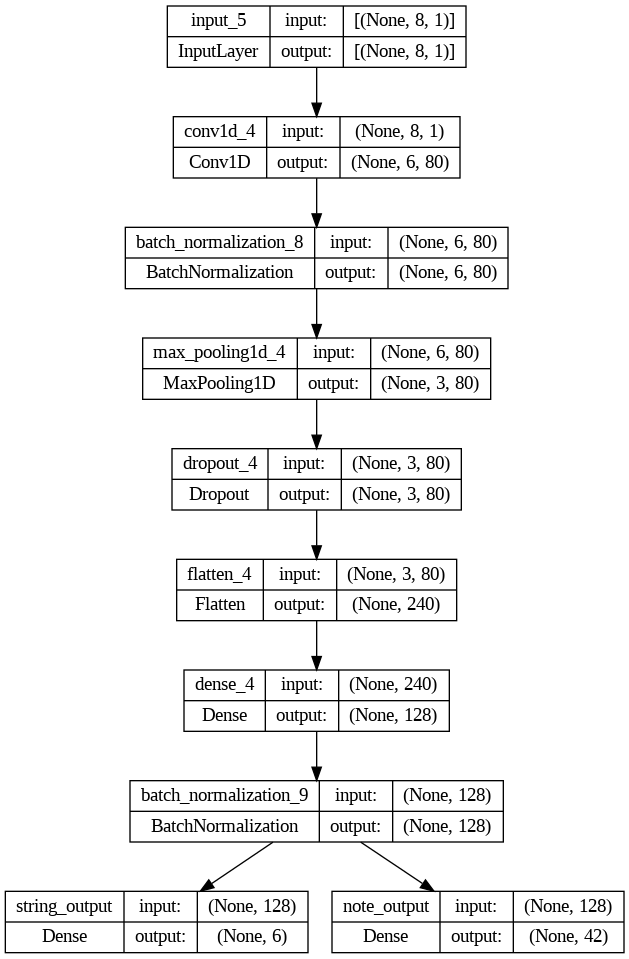

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)



#Building the model with best parameters and retraining

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, {'string_output': y_string_train_one_hot, 'note_output': y_note_train_one_hot}, epochs=10,
                    validation_data=(X_test, {'string_output': y_string_test_one_hot, 'note_output': y_note_test_one_hot}))

# print training and validation loss, precision, recall, auc, f1 score, and accuracy for every 2nd epoch
for i in range(len(history.history['loss'])):
    if (i+1) % 2 == 0:
        print(f"Epoch {i+1}:")
        print(f"  Training Loss: {history.history['loss'][i]}")
        print(f"  Training String Accuracy: {history.history['string_output_accuracy'][i]}") # Training String Accuracy
        print(f"  Training Note Accuracy: {history.history['note_output_accuracy'][i]}") # Training Note Accuracy
        print(f"  Training String Precision: {history.history['string_output_precision'][i]}")
        print(f"  Training Note Precision: {history.history['note_output_precision'][i]}")
        print(f"  Training String Recall: {history.history['string_output_recall'][i]}")
        print(f"  Training Note Recall: {history.history['note_output_recall'][i]}")
        print(f"  Training String F1 Score: {history.history['string_output_f1_score'][i]}")
        print(f"  Training Note F1 Score: {history.history['note_output_f1_score'][i]}")
        print(f"  Training String AUC: {history.history['string_output_auc'][i]}")
        print(f"  Training Note AUC: {history.history['note_output_auc'][i]}")
        print(f"  Validation String Loss: {history.history['val_string_output_loss'][i]}")
        print(f"  Validation Note Loss: {history.history['val_note_output_loss'][i]}")
        print(f"  Validation String Accuracy: {history.history['val_string_output_accuracy'][i]}") # Validation String Accuracy
        print(f"  Validation Note Accuracy: {history.history['val_note_output_accuracy'][i]}") # Validation Note Accuracy
        print(f"  Validation String Precision: {history.history['val_string_output_precision'][i]}")
        print(f"  Validation Note Precision: {history.history['val_note_output_precision'][i]}")
        print(f"  Validation String Recall: {history.history['val_string_output_recall'][i]}")
        print(f"  Validation Note Recall: {history.history['val_note_output_recall'][i]}")
        print(f"  Validation String F1 Score: {history.history['val_string_output_f1_score'][i]}")
        print(f"  Validation Note F1 Score: {history.history['val_note_output_f1_score'][i]}")
        print(f"  Validation String AUC: {history.history['val_string_output_auc'][i]}")
        print(f"  Validation Note AUC: {history.history['val_note_output_auc'][i]}")


Epoch 1/10
5295/5295 [==============================] - 45s 8ms/step - loss: 3.5001 - string_output_loss: 0.7127 - note_output_loss: 2.5789 - string_output_precision: 0.7308 - string_output_recall: 0.6361 - string_output_f1_score: 0.6802 - string_output_auc: 0.9456 - string_output_accuracy: 0.6965 - note_output_precision: 0.6995 - note_output_recall: 0.0078 - note_output_f1_score: 0.0154 - note_output_auc: 0.8928 - note_output_accuracy: 0.1717 - val_loss: 3.1921 - val_string_output_loss: 0.6427 - val_note_output_loss: 2.3495 - val_string_output_precision: 0.7550 - val_string_output_recall: 0.7090 - val_string_output_f1_score: 0.7313 - val_string_output_auc: 0.9558 - val_string_output_accuracy: 0.7350 - val_note_output_precision: 0.2694 - val_note_output_recall: 0.0042 - val_note_output_f1_score: 0.0082 - val_note_output_auc: 0.9300 - val_note_output_accuracy: 0.2306
Epoch 2/10
5295/5295 [==============================] - 41s 8ms/step - loss: 2.9186 - string_output_loss: 0.5719 - note_o

#Model Evaluation

391/391 [==============================] - 1s 2ms/step
Classification Report for String:
           precision    recall  f1-score
1           0.836649  0.866594  0.851359
2           0.839246  0.834160  0.836695
3           0.814827  0.830143  0.822414
4           0.706092  0.789894  0.745646
5           0.753384  0.701181  0.726346
6           0.897317  0.724963  0.801984
accuracy    0.786252  0.786252  0.786252
macro avg   0.807919  0.791156  0.797407
Classification Report for Note:
           precision    recall  f1-score
A2          0.361502  0.339207  0.350000
A3          0.301887  0.339823  0.319734
A4          0.311404  0.250883  0.277886
A♯2         0.236111  0.089947  0.130268
A♯3         0.282443  0.301303  0.291568
A♯4         0.213166  0.303571  0.250460
B2          0.280443  0.319328  0.298625
B3          0.277691  0.310646  0.293245
B4          0.211679  0.162011  0.183544
C3          0.299003  0.338346  0.317460
C4          0.307087  0.254486  0.278323
C5          0.2656

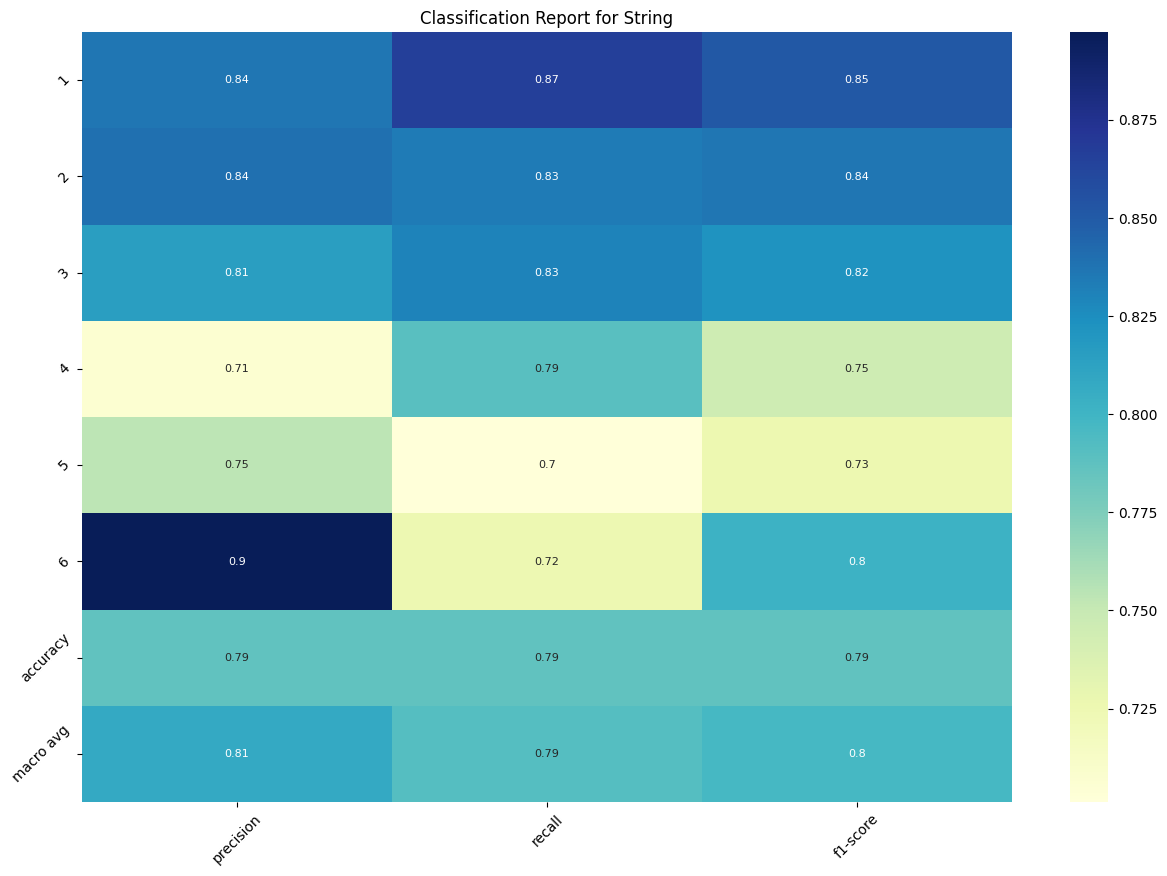

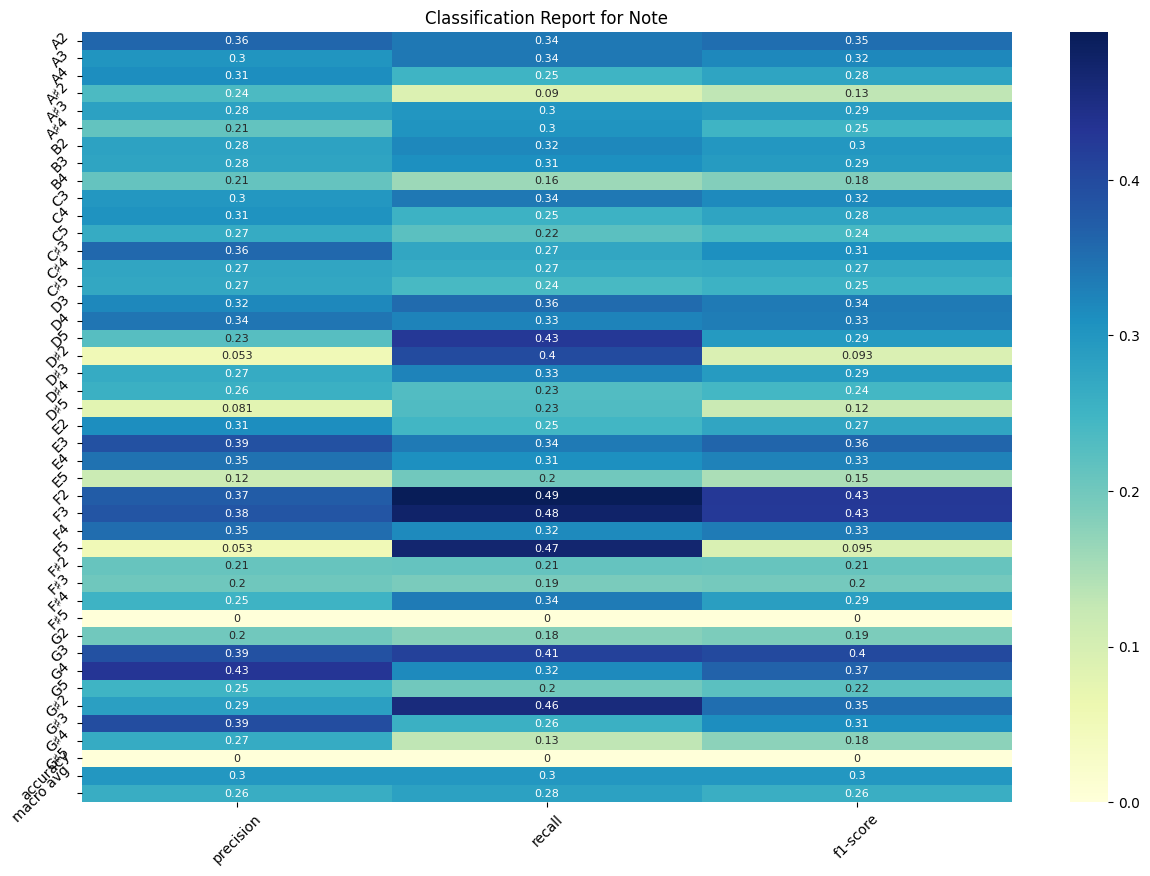

In [ ]:
# Predict the classes for the test set
y_pred_string, y_pred_note = model.predict(X_test)

# Convert predictions to class labels
y_pred_string_classes = np.argmax(y_pred_string, axis=1)
y_pred_note_classes = np.argmax(y_pred_note, axis=1)

# Convert one-hot encoded labels back to class labels
y_true_string_classes = np.argmax(y_string_test_one_hot, axis=1)
y_true_note_classes = np.argmax(y_note_test_one_hot, axis=1)

# Generate the classification report for string
report_string = classification_report(y_true_string_classes, y_pred_string_classes, target_names=[str(c) for c in string_encoder.classes_], output_dict=True)
df_report_string = pd.DataFrame(report_string).transpose().drop('support', axis=1).iloc[:-1, :] # Exclude non-numeric rows/columns
print("Classification Report for String:")
print(df_report_string)

# Generate the classification report for note
report_note = classification_report(y_true_note_classes, y_pred_note_classes, target_names=[str(c) for c in note_encoder.classes_], output_dict=True)
df_report_note = pd.DataFrame(report_note).transpose().drop('support', axis=1).iloc[:-1, :] # Exclude non-numeric rows/columns
print("Classification Report for Note:")
print(df_report_note)

def plot_classification_report(df_report, title):
    plt.figure(figsize=(15, 10)) # Increase figure size
    sns.heatmap(df_report, annot=True, cmap="YlGnBu", annot_kws={"size": 8}) # Adjust annotation font size
    plt.xticks(rotation=45) # Rotate x-axis labels
    plt.yticks(rotation=45) # Rotate y-axis labels (if needed)
    plt.title(title)
    plt.show()

# Plotting the classification report for string
plot_classification_report(df_report_string, "Classification Report for String")

# Plotting the classification report for note
plot_classification_report(df_report_note, "Classification Report for Note")


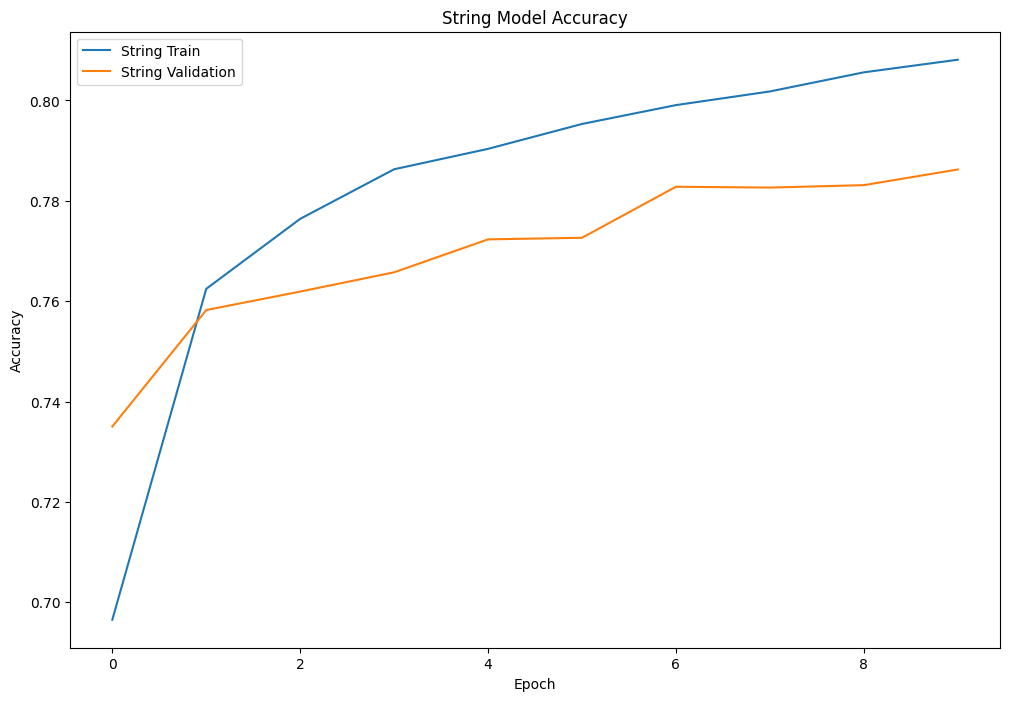

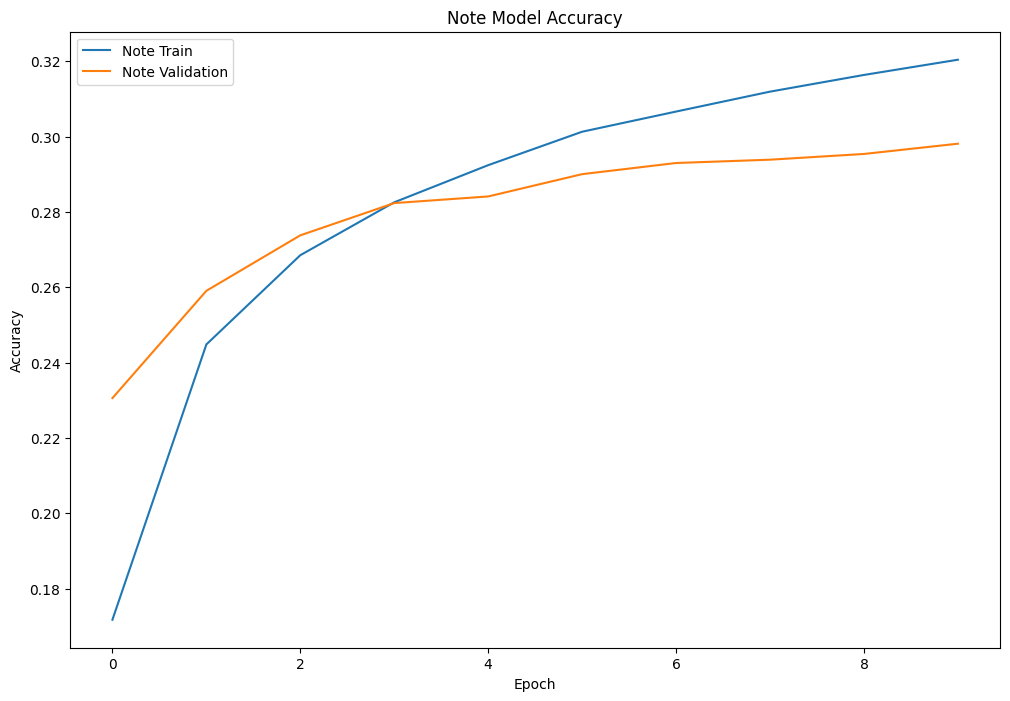

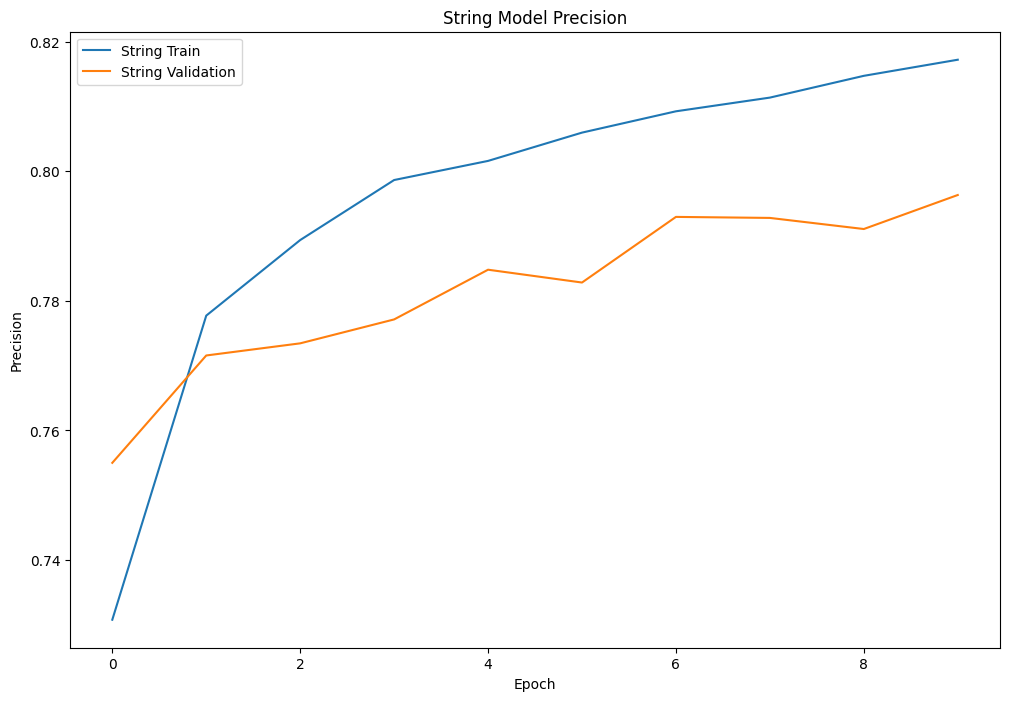

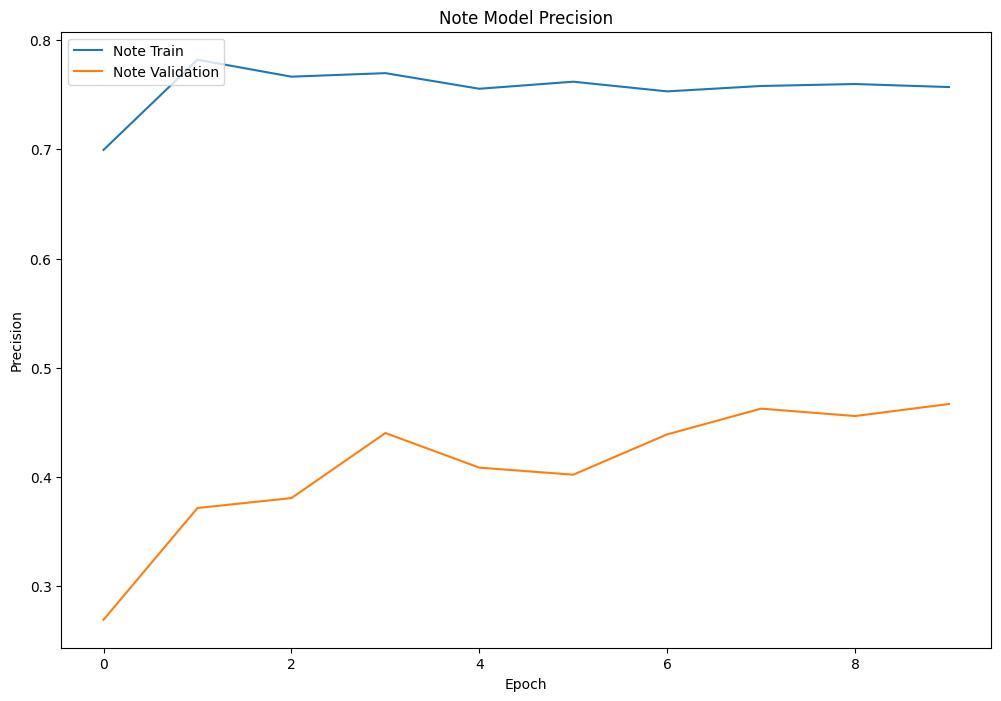

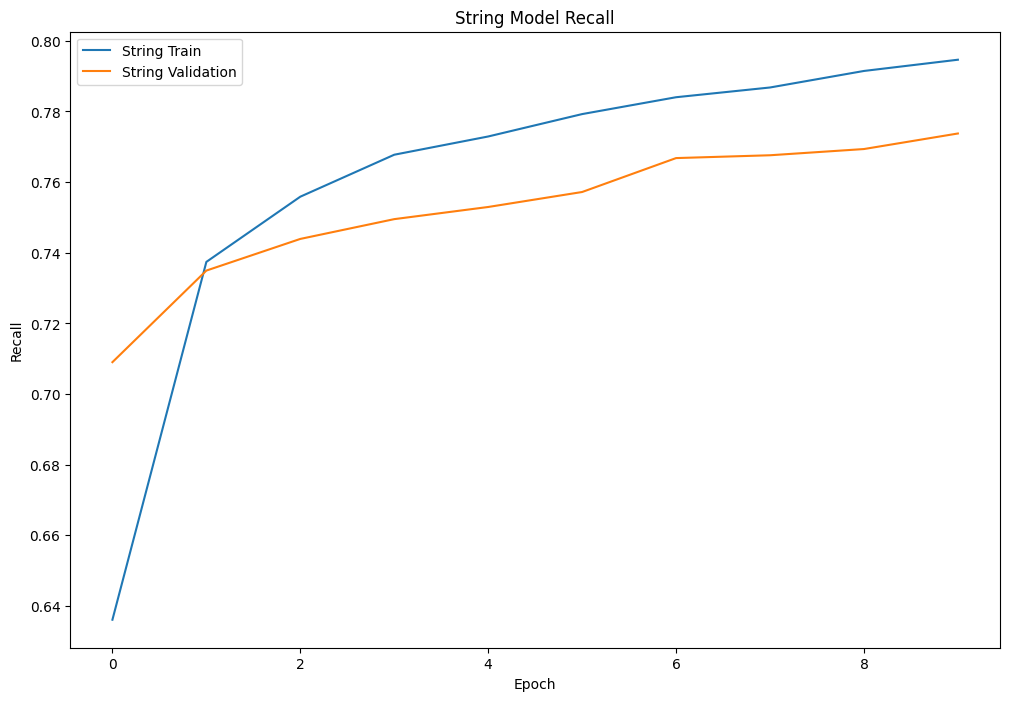

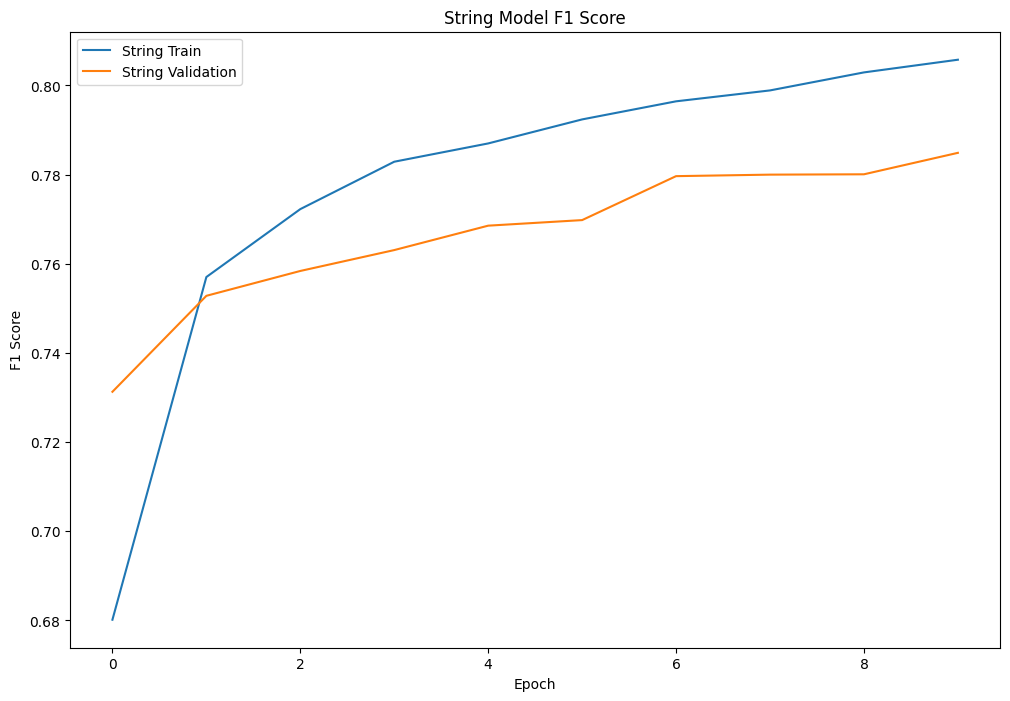

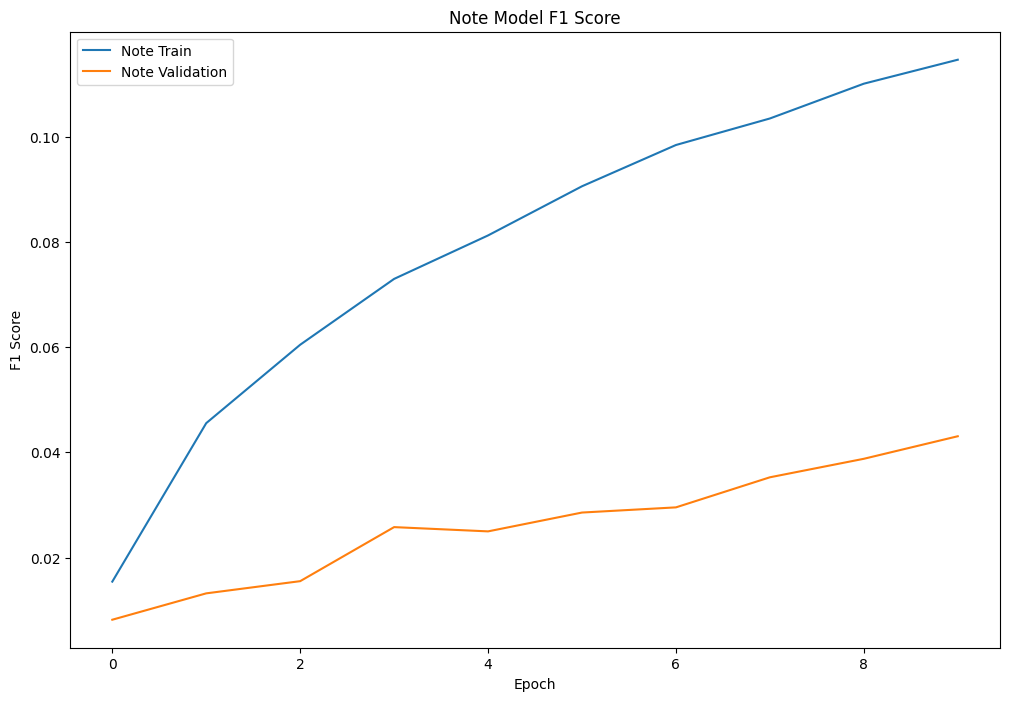

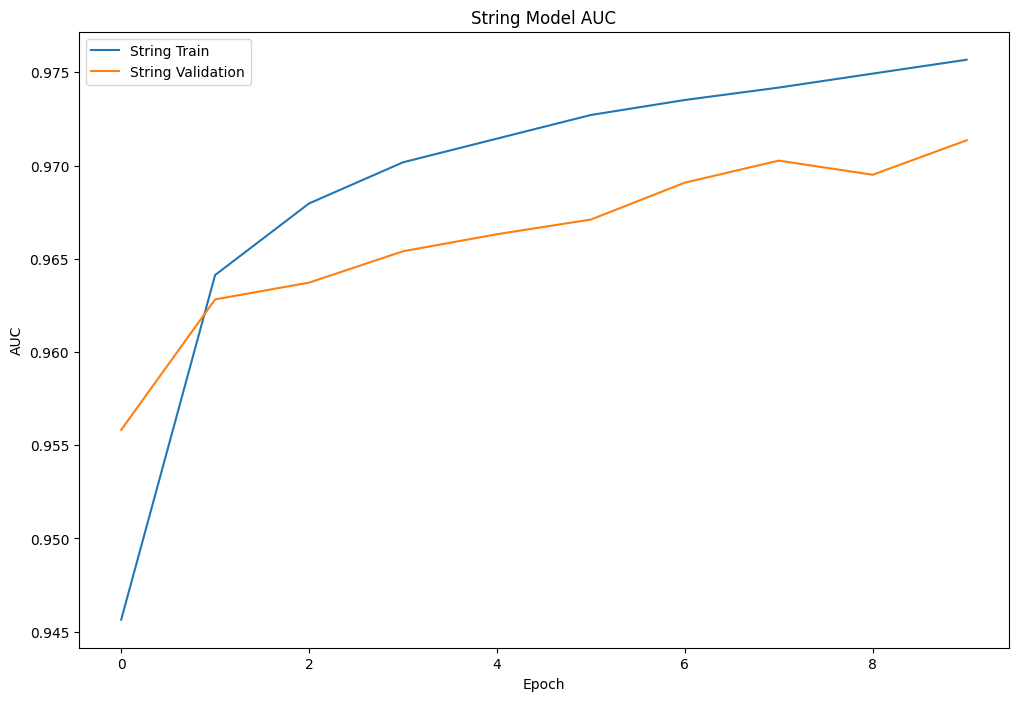

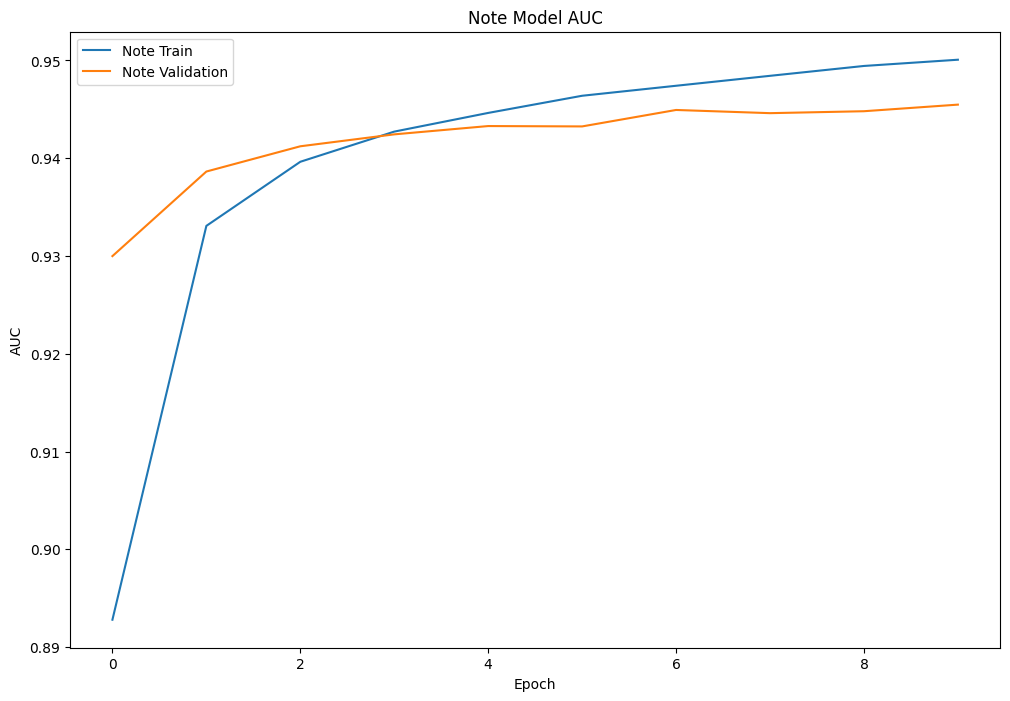

In [ ]:
# Function to plot a metric for a specific output
def plot_metric(output_name, metric_name, title, ylabel):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history[f'{output_name}_output_{metric_name}'])
    plt.plot(history.history[f'val_{output_name}_output_{metric_name}'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend([f'{output_name.capitalize()} Train', f'{output_name.capitalize()} Validation'], loc='upper left')
    plt.show()

# Function to plot metrics for both strings and notes
def plot_metrics_for_both(metric_name, title, ylabel):
    plot_metric('string', metric_name, f'String {title}', ylabel)
    plot_metric('note', metric_name, f'Note {title}', ylabel)

# Plot accuracy
plot_metrics_for_both('accuracy', 'Model Accuracy', 'Accuracy')

# Plot precision
plot_metrics_for_both('precision', 'Model Precision', 'Precision')

# Plot recall
plot_metrics_for_both('recall', 'Model Recall', 'Recall')

# Plot F1 score
plot_metrics_for_both('f1_score', 'Model F1 Score', 'F1 Score')

# Plot AUC
plot_metrics_for_both('auc', 'Model AUC', 'AUC')
